In [ ]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
from read_data import data_reader

train_data = data_reader()
train_data.read('bl_train_data_stopwords.csv')

valid_data = data_reader()
valid_data.read('vali_data_rev.csv')
valid_size = valid_data.data.shape[0]



loading  bl_train_data_stopwords.csv ...


In [ ]:
learning_rate = 0.003
training_iters = 200000
batch_size =100
display_step = 10


n_input = 300 # dimension of word2vec embedding
n_steps = 100 # maximum text length
n_hidden = 50 # hidden layer num of features
# n_hidden_2 = 50
n_classes = 5 # number of classes


tf.reset_default_graph()

# tf Graph input
# x = tf.placeholder("float", [None, n_steps, n_input])
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
input_size = tf.placeholder(tf.int32, [None])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]), name = 'weights')
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]), name = 'bias')
}


def RNN(x, input_size, weights, biases):
    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)
#     x = tf.unstack(x, None, 0)
#     print(x.shape)
    # Define a lstm cell with tensorflow
#     x = tf.stack(x)
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    lstm_cell = rnn.DropoutWrapper(lstm_cell, input_keep_prob=0.5, output_keep_prob=0.5)
#     lstm_cell_2 = rnn.BasicLSTMCell(n_hidden_2, forget_bias=1.0)
#     lstm_cell_2 = rnn.DropoutWrapper(lstm_cell_2, input_keep_prob=0.5, output_keep_prob=0.5)
    lstm_cell = rnn.MultiRNNCell([lstm_cell, lstm_cell] )

    # Get lstm cell output
#     outputs, states = rnn.static_rnn(cell=lstm_cell, inputs=x, sequence_length=input_size, dtype=tf.float32)
    outputs, states = rnn.static_rnn(cell=lstm_cell, inputs=x, dtype=tf.float32)
#     outputs, states = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=x, sequence_length=input_size, dtype=tf.float32)
#     outputs = tf.unstack(outputs, n_steps, 1)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out'], outputs[-1]



pred, out = RNN(x, input_size, weights, biases)



# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()


# recording of embedded text and review
embedding = None
labels = None

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        # batch_x, batch_y = mnist.train.next_batch(batch_size)
        if step % 100 == 0:
            learning_rate *= 0.9

        batch_x, batch_y, size = train_data.next_batch(batch_size)

        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, input_size: size})
        if step % (display_step * 10)== 0:
            # Calculate batch accuracy
            
            train_x, train_y = train_data.next_batch(valid_size, whole=True)
            acc = sess.run(accuracy, feed_dict={x: train_x, y: train_y, input_size: size})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: train_x, y: train_y, input_size: size})
            log = "Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
            with open('log.txt','a') as f:
                f.write(log + '\n')
            print (log)
        if step % (display_step * 10) == 0:
            valid_x, valid_y = valid_data.next_batch(valid_size, whole=True)
            valid_x = valid_x.reshape((valid_size, n_steps, n_input))
            acc = sess.run(accuracy, feed_dict={x: valid_x, y: valid_y, input_size: size})
            log = 'Validation Accuracy: ' + str(acc)
            with open('log.txt','a') as f:
                f.write(log + '\n')
            print(log)
        step += 1
    print ("Optimization Finished!")

    valid_x, valid_y = valid_data.next_batch(valid_size, whole=True)
    valid_x = valid_x.reshape((valid_size, n_steps, n_input))
    acc = sess.run(accuracy, feed_dict={x: valid_x, y: valid_y, input_size: size})
    embedding = sess.run(out, feed_dict={x: valid_x})
    pred_labels = sess.run(tf.argmax(pred,1), feed_dict={x: valid_x})
    labels = sess.run(tf.argmax(valid_y,1), feed_dict={y: valid_y})
    confuse_mat = np.zeros((5,5))
    for i in range(labels.shape[0]):
        confuse_mat[labels[i],pred_labels[i]] += 1
    print(confuse_mat)
    np.savetxt('confusion_matrix.txt', confuse_mat)
    np.savetxt('embedding.txt',embedding)
    np.savetxt('rating.txt',labels)
    np.savetxt('predicted.txt',pred_labels)

    print('Validation Accuracy: ', acc)
    
    # Calculate accuracy for 128 mnist test images
    # test_len = 128
    # test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    # test_label = mnist.test.labels[:test_len]
    # print ("Testing Accuracy:", \
    #     sess.run(accuracy, feed_dict={x: test_data, y: test_label}))



In [7]:
print(embedding.shape)
print(labels.shape)

(4000, 50)
(4000,)


In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline 


pca = PCA(n_components=2)
embedding_new = pca.fit_transform(embedding)


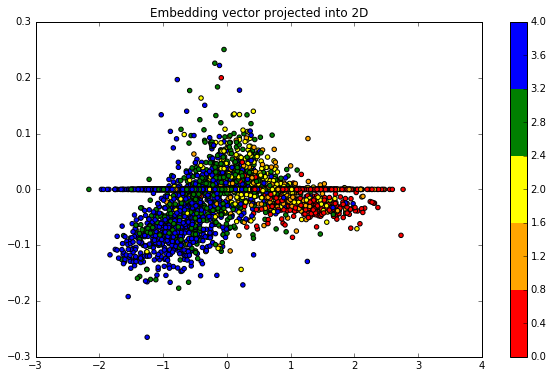

In [15]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D


# fig = plt.figure(figsize=(10, 6))
# ax = fig.gca(projection='3d')
# colors = ['red','orange','yellow','green','blue']
# p = ax.scatter(embedding_new[:,0],embedding[:,1],embedding[:,2],c=labels,cmap=matplotlib.colors.ListedColormap(colors))
# ax.view_init(45,80)
# fig.colorbar(p)
# ax.set_title('Embedding vector projected into 3D')
# fig.savefig('3d.png')

plt.figure(figsize=(10, 6))
colors = ['red','orange','yellow','green','blue']
plt.scatter(embedding_new[:,0],embedding[:,1],c=labels,cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar()
plt.title('Embedding vector projected into 2D')
plt.savefig('2d.png')